<a href="https://colab.research.google.com/github/krisparashkevov17/friendly-dmt/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Install packages
!pip install datasets transformers==4.51.3 torch==2.3.0 torchvision==0.18.0 --force-reinstall
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 7.6 MB/s eta 0:00:00
ERROR: Operation cancelled by user
^C


In [2]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer, DistilBertTokenizer, EarlyStoppingCallback
import torch
import pandas as pd
import os
import ast
from datasets import Dataset, load_from_disk
import warnings
import torch
import re
import torchvision
from collections import defaultdict

In [3]:
# Import for statistical analysis
!pip install pingouin
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import f_oneway, ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 10.1 MB/s eta 0:00:00


In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Load data from survey and data for fine-tuning
survey_df = pd.read_csv("/content/drive/MyDrive/human_participants.csv", skiprows=[1,2])
pl_df = pd.read_csv('/content/drive/MyDrive/premierleague.csv')

# Sentences
sentences = [
    # General knowledge sentences
    "To unlock the door, she used her [MASK].",
    "She was late for work because she missed the [MASK].",
    "Before going to bed, he turned off the [MASK].",
    "A dog wags its tail when it feels [MASK].",
    "The girl added sugar to her [MASK].",
    # Football-specific sentences
    "The winger was offside after running past the last [MASK].",
    "The striker nutmegged the defender and shot past the [MASK].",
    "To hold their lead, the coach instructed the team to park the [MASK].",
    "Despite the strikers’ efforts, the keeper kept a clean [MASK].",
    "The midfielder spotted the striker’s run and delivered a perfect through [MASK]."
]

# Sentence types
sentence_types = {sentences[i]: "general" if i < 5 else "football" for i in range(10)}
#survey_df

In [ ]:
# Clean and prepare football sentences for fine-tuning
def clean_text(text):
    try:
        if pd.isna(text):
            return []
        text = str(text).strip()
        text = re.sub(r'\s+', ' ', text)
        sentences = re.split(r'[.!?]+', text)
        football_terms = ["park the bus", "clean sheet", "nutmeg", "goalkeeper", "defender",
            "through ball", "offside", "striker", "midfielder", "goal", "assist",
            "free kick", "penalty", "corner", "tackle", "dribble", "header",
            "shot", "save", "counter attack", "ball"]
        return [s.strip() for s in sentences if s.strip() and any(term in s.lower() for term in football_terms)]
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return []

event_sentences = []
for event in pl_df["events"].dropna().tolist(): # Target column
    event_sentences.extend(clean_text(event))

# Create Dataset
dataset = Dataset.from_list([{"events": sentence} for sentence in event_sentences])

# Split: 80% train, 10% validation, 10% test
train_temp = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_temp["train"]
val_test = train_temp["test"].train_test_split(test_size=0.5, seed=42)
validation_dataset = val_test["train"]
test_dataset = val_test["test"]

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device)
model.eval()

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(
        examples["events"],
        padding="max_length",
        truncation=True,
        max_length=128
        )

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["events"])
tokenized_validation = validation_dataset.map(tokenize_function, batched=True, remove_columns=["events"])
tokenized_test = test_dataset.map(tokenize_function, batched=True, remove_columns=["events"])

# Data collator for MLM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/soccer_distilbert",
    overwrite_output_dir=True,
    eval_strategy="steps",
    eval_steps=500,
    learning_rate=3e-5,
    num_train_epochs=5,
    max_steps=5000,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    save_steps=500,
    weight_decay=0.01,
    fp16=True,
    logging_dir="/content/drive/MyDrive/soccer_distilbert/logs",
    logging_steps=100,
    report_to="tensorboard",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_validation,
    data_collator=data_collator
)

# Train
trainer.train()

# Evaluate
eval_results = trainer.evaluate(eval_dataset=tokenized_test)
print(f"Test Loss: {eval_results['eval_loss']:.4f}")

# Save model
trainer.save_model("/content/drive/MyDrive/soccer_distilbert")

Map:   0%|          | 0/15549 [00:00<?, ? examples/s]

Map:   0%|          | 0/1944 [00:00<?, ? examples/s]

Map:   0%|          | 0/1944 [00:00<?, ? examples/s]

KeyboardInterrupt: 

In [7]:
# Define experts and non-experts
expert_levels = ["Big fan - I watch or play a lot.", "Pretty into it - I follow teams or leagues."]
non_expert_levels = ["A little - I catch a game now and then.", "Not at all - I barely know the rules."]

# Word variants
word_variants = {
    "goalie": "goalkeeper", "gk": "goalkeeper", "keeper": "goalkeeper",
    "heppy": "happy", "buss": "bus", "coffe": "coffee", "deffender": "defender"
}

# Normalize
for q in range(1, 11):
    col = f"Q{q}"
    survey_df[col] = (
        survey_df[col]
        .astype(str)
        .str.lower()
        .str.strip()
        .replace(word_variants)
    )

# Create subsets
experts_df = survey_df[survey_df["Q15"].isin(expert_levels)].copy()
non_experts_df = survey_df[survey_df["Q15"].isin(non_expert_levels)].copy()

# Count participants
print(f"Experts: {len(experts_df)}, Non-experts: {len(non_experts_df)}")

# Extract target words and probabilities
target_words = []
expert_probs = []
non_expert_probs = []

for q in range(1, 11):
    col = f"Q{q}"
    try:
        # Get expert mode
        expert_mode = experts_df[col].mode()[0] if not experts_df[col].mode().empty else "N/A"

        # Calculate probabilities
        expert_prob = experts_df[col].value_counts(normalize=True).get(expert_mode, 0)
        non_expert_prob = non_experts_df[col].value_counts(normalize=True).get(expert_mode, 0)

        target_words.append(expert_mode)
        expert_probs.append(expert_prob)
        non_expert_probs.append(non_expert_prob)
    except KeyError:
        print(f"Warning: Missing {col}")
        target_words.append("N/A")
        expert_probs.append(0)
        non_expert_probs.append(0)

# Load models
non_finetuned_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
non_finetuned_model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased").to(device).eval()

fine_tuned_model = AutoModelForMaskedLM.from_pretrained("/content/drive/MyDrive/soccer_distilbert").to(device).eval()
fine_tuned_tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/soccer_distilbert")

# Prediction function
def get_predictions(model, tokenizer, sentence, target_word, top_k=5):
    try:
        inputs = tokenizer(sentence, return_tensors="pt").to(device)
        mask_pos = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1][0]

        with torch.no_grad():
            logits = model(**inputs).logits[0, mask_pos]
            probs = torch.softmax(logits, dim=-1)

        # Target probability
        target_prob = 0
        if target_word != "N/A":
            target_id = tokenizer.convert_tokens_to_ids(target_word)
            if target_id != tokenizer.unk_token_id:
                target_prob = probs[target_id].item()

        # Get and filter top predictions
        top_ids = torch.topk(probs, top_k*5).indices
        top_tokens = tokenizer.convert_ids_to_tokens(top_ids)
        top_probs = probs[top_ids].cpu().numpy()

        predictions = [
            (token, prob)
            for token, prob in zip(top_tokens, top_probs)
            if token not in {".", ",", ";", "!", "?", ":", "(", ")"}
            and not token.startswith("##")
            and token not in tokenizer.all_special_tokens
        ][:top_k]

        return predictions, target_prob

    except Exception as e:
        print(f"Prediction failed: {str(e)}")
        return [("error", 0)], 0

# Generate predictions
results = []
for i, (sentence, target_word, expert_prob, non_expert_prob) in enumerate(zip(sentences, target_words, expert_probs, non_expert_probs)):
    print(f"Processing sentence {i+1}: {sentence}")

    # Human responses
    expert_response = target_word
    col = f"Q{i+1}"
    non_expert_response = non_experts_df[col].mode().iloc[0] if not non_experts_df[col].mode().empty else "N/A"

    # Model predictions
    base_preds, base_prob = get_predictions(non_finetuned_model, non_finetuned_tokenizer, sentence, target_word)
    ft_preds, ft_prob = get_predictions(fine_tuned_model, fine_tuned_tokenizer, sentence, target_word)

    results.append({
        "Sentence": sentence.replace(" [MASK].", ""),
        "Sentence Type": sentence_types[sentence],
        "Target Word": target_word,
        "Expert Response": expert_response,
        "Expert Probability": expert_prob,
        "Non-Expert Response": non_expert_response,
        "Non-Expert Probability": non_expert_prob,
        "Non-Fine-Tuned Model Response": base_preds[0][0],
        "Non-Fine-Tuned Model Probability": base_prob,
        "Fine-Tuned Model Response": ft_preds[0][0],
        "Fine-Tuned Model Probability": ft_prob,
        "Non-Fine-Tuned Model Top 3": [p[0] for p in base_preds[:3]],
        "Fine-Tuned Model Top 3": [p[0] for p in ft_preds[:3]],
        "Non-Fine-Tuned Model Top 5": [p[0] for p in base_preds[:5]],
        "Fine-Tuned Model Top 5": [p[0] for p in ft_preds[:5]]
    })

print(f"Non-Fine-Tuned model on: {next(non_finetuned_model.parameters()).device}")
print(f"Fine-tuned model on: {next(fine_tuned_model.parameters()).device}")

print(f"Non-Fine-Tuned model in eval mode: {not non_finetuned_model.training}")
print(f"Fine-tuned model in eval mode: {not fine_tuned_model.training}")

# Create output DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.round(4)

# Print comparison table
print("\nCloze Task Predictions and Probabilities:")
print(results_df[[
    "Sentence Type", "Sentence", "Target Word",
    "Expert Response", "Expert Probability",
    "Non-Expert Response", "Non-Expert Probability",
    "Non-Fine-Tuned Model Response", "Non-Fine-Tuned Model Probability",
    "Fine-Tuned Model Response", "Fine-Tuned Model Probability"
]].to_string(index=False))

# Highlight "park the bus" sentence
print("\n'Park the Bus' Sentence:")
bus_row = results_df[results_df["Sentence"] == "To hold their lead, the coach instructed the team to park the"]
print(bus_row[[
    "Sentence Type", "Sentence", "Target Word",
    "Expert Response", "Expert Probability",
    "Non-Expert Response", "Non-Expert Probability",
    "Non-Fine-Tuned Model Response", "Non-Fine-Tuned Model Probability",
    "Fine-Tuned Model Response", "Fine-Tuned Model Probability"
]].to_string(index=False))

# Save
results_df.to_csv("/content/drive/MyDrive/cloze_results.csv", index=False)

Experts: 56, Non-experts: 54


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Processing sentence 1: To unlock the door, she used her [MASK].
Processing sentence 2: She was late for work because she missed the [MASK].
Processing sentence 3: Before going to bed, he turned off the [MASK].
Processing sentence 4: A dog wags its tail when it feels [MASK].
Processing sentence 5: The girl added sugar to her [MASK].
Processing sentence 6: The winger was offside after running past the last [MASK].
Processing sentence 7: The striker nutmegged the defender and shot past the [MASK].
Processing sentence 8: To hold their lead, the coach instructed the team to park the [MASK].
Processing sentence 9: Despite the strikers’ efforts, the keeper kept a clean [MASK].
Processing sentence 10: The midfielder spotted the striker’s run and delivered a perfect through [MASK].
Non-Fine-Tuned model on: cpu
Fine-tuned model on: cpu
Non-Fine-Tuned model in eval mode: True
Fine-tuned model in eval mode: True

Cloze Task Predictions and Probabilities:
Sentence Type                              

In [8]:
sentence_index =  6 # Index of the "past the goalkeeper" sentence
word_to_check = "goalkeeper"

# Get the full probability distribution
def get_word_prob(model, tokenizer, sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    mask_pos = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1][0]

    with torch.no_grad():
        logits = model(**inputs).logits[0, mask_pos]
        probs = torch.softmax(logits, dim=-1)
        word_id = tokenizer.convert_tokens_to_ids(word)
        return probs[word_id].item() if word_id != tokenizer.unk_token_id else 0

specific_sentence = sentences[sentence_index]
base_prob = get_word_prob(non_finetuned_model, non_finetuned_tokenizer, specific_sentence, word_to_check)
ft_prob = get_word_prob(fine_tuned_model, fine_tuned_tokenizer, specific_sentence, word_to_check)

print(f"\nProbability for '{word_to_check}' in sentence {sentence_index+1}:")
print(f"Non-fine-tuned model: {base_prob:.4f}")
print(f"Fine-tuned: {ft_prob:.4f}")
print(f"Human expert: {results[sentence_index]['Expert Probability']:.2f}")

sentence_index = 7  # Index of the "park the bus" sentence
word_to_check = "bus"

# Get the full probability distribution
def get_word_prob(model, tokenizer, sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    mask_pos = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1][0]

    with torch.no_grad():
        logits = model(**inputs).logits[0, mask_pos]
        probs = torch.softmax(logits, dim=-1)
        word_id = tokenizer.convert_tokens_to_ids(word)
        return probs[word_id].item() if word_id != tokenizer.unk_token_id else 0

specific_sentence = sentences[sentence_index]
base_prob = get_word_prob(non_finetuned_model, non_finetuned_tokenizer, specific_sentence, word_to_check)
ft_prob = get_word_prob(fine_tuned_model, fine_tuned_tokenizer, specific_sentence, word_to_check)

print(f"\nProbability for '{word_to_check}' in sentence {sentence_index+1}:")
print(f"Non-fine-tuned model: {base_prob:.4f}")
print(f"Fine-tuned: {ft_prob:.4f}")
print(f"Human expert: {results[sentence_index]['Expert Probability']:.2f}")

sentence_index = 9  # Index of the "through ball" sentence
word_to_check = "ball"

# Get the full probability distribution
def get_word_prob(model, tokenizer, sentence, word):
    inputs = tokenizer(sentence, return_tensors="pt").to(device)
    mask_pos = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1][0]

    with torch.no_grad():
        logits = model(**inputs).logits[0, mask_pos]
        probs = torch.softmax(logits, dim=-1)
        word_id = tokenizer.convert_tokens_to_ids(word)
        return probs[word_id].item() if word_id != tokenizer.unk_token_id else 0

specific_sentence = sentences[sentence_index]
base_prob = get_word_prob(non_finetuned_model, non_finetuned_tokenizer, specific_sentence, word_to_check)
ft_prob = get_word_prob(fine_tuned_model, fine_tuned_tokenizer, specific_sentence, word_to_check)

print(f"\nProbability for '{word_to_check}' in sentence {sentence_index+1}:")
print(f"Non-fine-tuned model: {base_prob:.4f}")
print(f"Fine-tuned: {ft_prob:.4f}")
print(f"Human expert: {results[sentence_index]['Expert Probability']:.2f}")


Probability for 'goalkeeper' in sentence 7:
Non-fine-tuned model: 0.1661
Fine-tuned: 0.2217
Human expert: 0.75

Probability for 'bus' in sentence 8:
Non-fine-tuned model: 0.0069
Fine-tuned: 0.0000
Human expert: 0.84

Probability for 'ball' in sentence 10:
Non-fine-tuned model: 0.0102
Fine-tuned: 0.0004
Human expert: 0.43


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

results_df['Accuracy FT'] = (results_df['Fine-Tuned Model Response'] == results_df['Target Word']).astype(int)
results_df['Accuracy'] = (results_df['Non-Fine-Tuned Model Response'] == results_df['Target Word']).astype(int)
results_df['Top 3 FT'] = results_df.apply(lambda x: int(x['Target Word'] in x['Fine-Tuned Model Top 3']), axis=1)
results_df['Top 3 NFT'] = results_df.apply(lambda x: int(x['Target Word'] in x['Non-Fine-Tuned Model Top 3']), axis=1)

for q in range(1, 11):
    col = f"Q{q}"
    expert_mode = experts_df[col].mode()[0]

# Prepare cosine similarity
def get_cosine(row):
    human_dist = np.array([row['Expert Probability'], 1-row['Expert Probability']])
    llm_dist = np.array([row['Fine-Tuned Model Probability'], 1-row['Fine-Tuned Model Probability']])
    return cosine_similarity([human_dist], [llm_dist])[0][0]

results_df['CosineSimilarity'] = results_df.apply(get_cosine, axis=1)
results_df['LogProbFT'] = np.log(results_df['Fine-Tuned Model Probability'] + 1e-10)
results_df['LogProbNFT'] = np.log(results_df['Non-Fine-Tuned Model Probability'] + 1e-10)

log_probs = results_df[['Sentence','Sentence Type','Target Word','Fine-Tuned Model Response','LogProbFT', 'Non-Fine-Tuned Model Response', 'LogProbNFT']]


results_df['SentenceType'] = results_df['Sentence Type']
results_df['ModelType'] = 'FineTuned'


results_df
results_df.to_csv("/content/drive/MyDrive/cloze_results.csv", index=False)
results_df

mean_cosine_general = results_df['CosineSimilarity'].iloc[0:5].mean()
sd_cosine_general = results_df['CosineSimilarity'].iloc[0:5].std()

mean_cosine_football = results_df['CosineSimilarity'].iloc[5:10].mean()
sd_cosine_football = results_df['CosineSimilarity'].iloc[5:10].std()

# Print results
print("Sentences 1-5:")
print(f"Mean CosineSimilarity: {mean_cosine_general:.4f}")
print(f"Standard Deviation: {sd_cosine_general:.4f}")
print("\nSentences 6-10:")
print(f"Mean CosineSimilarity: {mean_cosine_football:.4f}")
print(f"Standard Deviation: {sd_cosine_football:.4f}")

Sentences 1-5:
Mean CosineSimilarity: 0.5689
Standard Deviation: 0.1791

Sentences 6-10:
Mean CosineSimilarity: 0.7078
Standard Deviation: 0.3400


In [12]:
log_probs

,Sentence,Sentence Type,Target Word,Fine-Tuned Model Response,LogProbFT,Non-Fine-Tuned Model Response,LogProbNFT
0,"To unlock the door, she used her",general,key,arm,-6.812445,flashlight,-2.728763
1,She was late for work because she missed the,general,bus,ball,-23.025851,holidays,-5.184989
2,"Before going to bed, he turned off the",general,lights,ball,-4.688552,lamp,-2.209095
3,A dog wags its tail when it feels,general,happy,threatened,-9.210339,threatened,-6.812445
4,The girl added sugar to her,general,coffee,name,-9.210339,drink,-4.074542
5,The winger was offside after running past the ...,football,defender,defender,-0.250515,defender,-2.136224
6,The striker nutmegged the defender and shot pa...,football,goalkeeper,post,-1.506430,defender,-1.795165
7,"To hold their lead, the coach instructed the t...",football,bus,ball,-23.025851,ball,-4.976234
8,"Despite the strikers’ efforts, the keeper kept...",football,sheet,sheet,-0.026036,sheet,-0.254634
9,The midfielder spotted the striker’s run and d...,football,ball,kick,-7.824046,kick,-4.585368


In [10]:
# Calculate accuracy
results_df['Expert Accuracy'] = (results_df['Expert Response'] == results_df['Target Word']).astype(int)
results_df['Non-Expert Accuracy'] = (results_df['Non-Expert Response'] == results_df['Target Word']).astype(int)
results_df['Non-Fine-Tuned LLM Accuracy'] = (results_df['Non-Fine-Tuned Model Response'] == results_df['Target Word']).astype(int)
results_df['Fine-Tuned LLM Accuracy'] = (results_df['Fine-Tuned Model Response'] == results_df['Target Word']).astype(int)
results_df['Top 3 FT'] = results_df.apply(lambda x: int(x['Target Word'] in x['Fine-Tuned Model Top 3']), axis=1)
results_df['Top 3 NFT'] = results_df.apply(lambda x: int(x['Target Word'] in x['Non-Fine-Tuned Model Top 3']), axis=1)

# Summarize by sentence type
accuracy_summary = results_df.groupby('Sentence Type')[
    ['Expert Accuracy', 'Non-Expert Accuracy', 'Non-Fine-Tuned LLM Accuracy', 'Fine-Tuned LLM Accuracy','Top 3 FT', 'Top 3 NFT' ]
].mean().reset_index()

print("Accuracy Summary:")
print(accuracy_summary)

Accuracy Summary:
  Sentence Type  Expert Accuracy  Non-Expert Accuracy  \
0      football              1.0                  0.6   
1       general              1.0                  0.8   

   Non-Fine-Tuned LLM Accuracy  Fine-Tuned LLM Accuracy  Top 3 FT  Top 3 NFT  
0                          0.4                      0.4       0.8        0.6  
1                          0.0                      0.0       0.0        0.4  


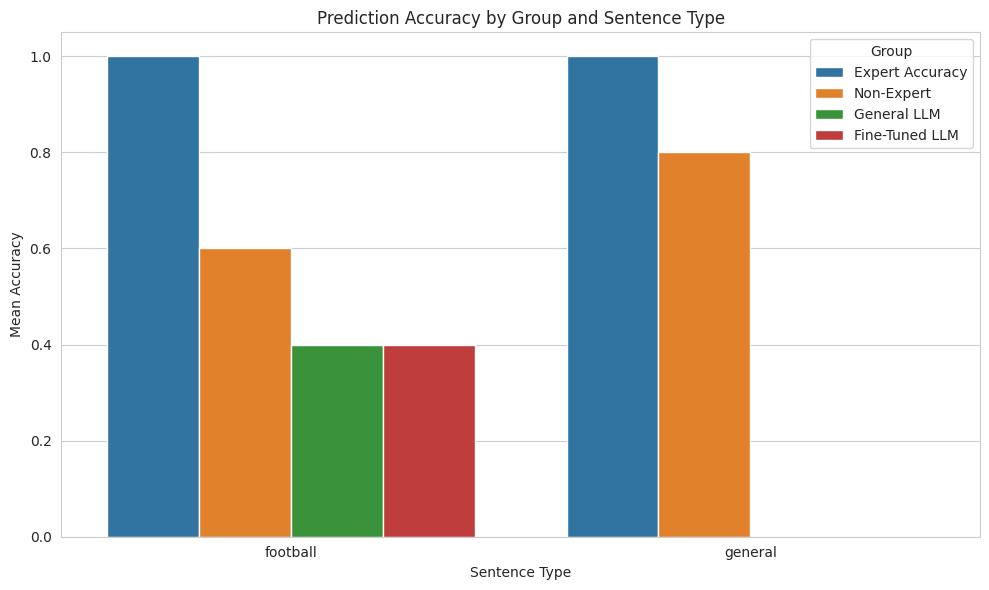

\Top-3 Data:
  Sentence Type           Model  Top3_Accuracy
0      football     General LLM            0.6
1       general     General LLM            0.4
2      football  Fine-Tuned LLM            0.8
3       general  Fine-Tuned LLM            0.0


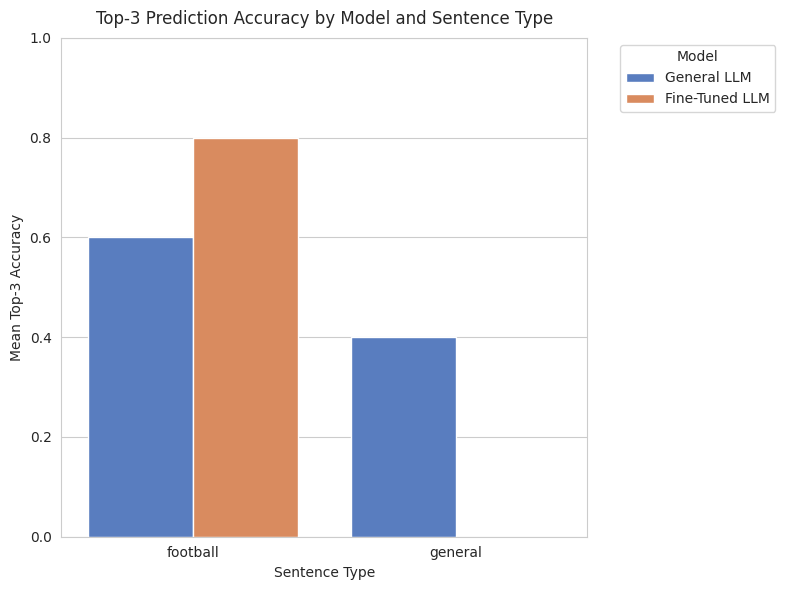

In [11]:
sns.set_style("whitegrid")

# Prediction Accuracy Bar Plot
accuracy_melted = accuracy_summary.melt(
    id_vars=['Sentence Type'],
    value_vars=['Expert Accuracy', 'Non-Expert Accuracy', 'Non-Fine-Tuned LLM Accuracy', 'Fine-Tuned LLM Accuracy'],
    var_name='Group',
    value_name='Accuracy'
)
accuracy_melted['Group'] = accuracy_melted['Group'].replace({
    'Expert_Accuracy': 'Expert',
    'Non-Expert Accuracy': 'Non-Expert',
    'Non-Fine-Tuned LLM Accuracy': 'General LLM',
    'Fine-Tuned LLM Accuracy': 'Fine-Tuned LLM'
})

plt.figure(figsize=(10, 6))
sns.barplot(data=accuracy_melted, x='Sentence Type', y='Accuracy', hue='Group')
plt.title('Prediction Accuracy by Group and Sentence Type')
plt.ylabel('Mean Accuracy')
plt.xlabel('Sentence Type')
plt.legend(title='Group')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/accuracy_group_sentence.png', dpi=300, bbox_inches='tight')
plt.show()

# Melt top-3 summary for plotting
top3_melted = accuracy_summary.melt(
    id_vars=['Sentence Type'],
    value_vars=['Top 3 NFT', 'Top 3 FT'],
    var_name='Model',
    value_name='Top3_Accuracy'
)
top3_melted['Model'] = top3_melted['Model'].replace({
    'Top 3 NFT': 'General LLM',
    'Top 3 FT': 'Fine-Tuned LLM'
})

# Verify data
print("\Top-3 Data:")
print(top3_melted)

# Plot
plt.figure(figsize=(8, 6))
g = sns.barplot(
    data=top3_melted,
    x='Sentence Type',
    y='Top3_Accuracy',
    hue='Model',
    palette='muted'
)
g.set_title('Top-3 Prediction Accuracy by Model and Sentence Type', pad=10)
g.set_ylabel('Mean Top-3 Accuracy')
g.set_xlabel('Sentence Type')
g.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/accuracy_top_3.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Experts and non-experts
expert_mask = survey_df['Q15'].isin(['Big fan - I watch or play a lot.',
                                   'Pretty into it - I follow teams or leagues.'])
experts = survey_df[expert_mask]
non_experts = survey_df[~expert_mask]

# Validate
football_mask = results_df['Sentence Type'].str.lower() == 'football'

# Target words
target_words = results_df[football_mask]['Target Word'].reset_index(drop=True)
football_cols = ['Q6', 'Q7', 'Q8', 'Q9', 'Q10'][:len(target_words)]  # Ensure equal length
print("Matching:")
for q, word in zip(football_cols, target_words):
    print(f"{q} → {word}")

# Accuracy (individual)
individual_acc = []
validation_data = defaultdict(list)

for group, group_df in [('Expert', experts), ('Non-Expert', non_experts)]:
    for idx, row in group_df.iterrows():
        correct = 0
        details = []

        for i, col in enumerate(football_cols):
            user_answer = str(row[col]).strip().lower()
            correct_answer = str(target_words[i]).strip().lower()
            is_correct = user_answer == correct_answer
            correct += int(is_correct)

            details.append({
                'question': col,
                'user_answer': user_answer,
                'correct_answer': correct_answer,
                'is_correct': is_correct
            })

        acc = (correct / len(football_cols)) * 100
        individual_acc.append({'Group': group, 'Accuracy': acc, 'Participant': idx})
        validation_data[idx].extend(details)

# Output
individual_acc_df = pd.DataFrame(individual_acc)
validation_df = pd.DataFrame(
    [item for sublist in validation_data.values() for item in sublist]
)

# Analyze
print("\nValidation summary:")
print(validation_df.groupby('question')['is_correct'].mean())

print("\nGroup accuracy summary:")
print(individual_acc_df.groupby('Group')['Accuracy'].describe())

# Visualize
pd.set_option('display.max_rows', 100)
print("\nSample response details:")
print(validation_df.head(20))
individual_acc_df

Matching:
Q6 → defender
Q7 → goalkeeper
Q8 → bus
Q9 → sheet
Q10 → ball

Validation summary:
question
Q10    0.290909
Q6     0.654545
Q7     0.590909
Q8     0.527273
Q9     0.536364
Name: is_correct, dtype: float64

Group accuracy summary:
            count       mean        std  min   25%   50%    75%    max
Group                                                                 
Expert       56.0  75.714286  25.786335  0.0  80.0  80.0  100.0  100.0
Non-Expert   54.0  27.407407  29.408328  0.0   0.0  20.0   40.0  100.0

Sample response details:
   question user_answer correct_answer  is_correct
0        Q6    defender       defender        True
1        Q7        goal     goalkeeper       False
2        Q8         bus            bus        True
3        Q9       sheet          sheet        True
4       Q10        ball           ball        True
5        Q6    defender       defender        True
6        Q7  goalkeeper     goalkeeper        True
7        Q8         bus            bus     

,Group,Accuracy,Participant
0,Expert,80.0,1
1,Expert,100.0,2
2,Expert,100.0,3
3,Expert,80.0,4
4,Expert,100.0,5
...,...,...,...
105,Non-Expert,0.0,103
106,Non-Expert,40.0,104
107,Non-Expert,20.0,105
108,Non-Expert,0.0,106


In [13]:
# Data for the boxplot
groups = ['Expert', 'Non-Expert']
data = [individual_acc_df[individual_acc_df['Group'] == group]['Accuracy'] for group in groups]

# Create figure and axis
plt.figure(figsize=(6, 4))

# Create boxplot
box = plt.boxplot(data, labels=groups, vert=True, patch_artist=True, widths=0.4)

# Customize colors
colors = ['#36A2EB', '#FF9F40']  # Blue for Expert, Orange for Non-Expert
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.3)
for whisker, cap, median in zip(box['whiskers'], box['caps'], box['medians']):
    whisker.set(color='#000000', linewidth=1)
    cap.set(color='#000000', linewidth=1)
    median.set(color='#000000', linewidth=2)

# Set labels and title
plt.ylabel('Accuracy (%)')
plt.xlabel('Expertise Group')
plt.title('Individual-Level Accuracy by Expertise Group')

# Set y-axis range and ticks
plt.ylim(0, 100)
plt.yticks(range(0, 101, 20))

# Adjust layout and save
plt.tight_layout()
plt.savefig('boxplot_accuracy.png', dpi=300, bbox_inches='tight')
plt.close()

In [14]:
def compare_accuracies(results_df, survey_df, individual_acc_df):
    "Compare human vs. LLM accuracies with appropriate statistical tests"

    football_mask = results_df['Sentence Type'].str.lower() == 'football'
    football_df = results_df[football_mask].copy()

    football_df['Sentence_ID'] = range(1, len(football_df) + 1)

    football_cols = ['Q6', 'Q7', 'Q8', 'Q9', 'Q10'][:len(football_df)]
    target_words = football_df['Target Word'].str.strip().str.lower().values

    sentence_acc = []
    for i, (col, target) in enumerate(zip(football_cols, target_words)):
        # Human accuracy (experts vs. non-experts)
        human_responses = survey_df[col].astype(str).str.strip().str.lower()
        correct = (human_responses == target).astype(int)
        acc_human = correct.mean() * 100

        # LLM accuracies
        acc_general_llm = football_df['Non-Fine-Tuned LLM Accuracy'].iloc[i]
        acc_finetuned_llm = football_df['Fine-Tuned LLM Accuracy'].iloc[i]

        sentence_acc.append({
            'Sentence_ID': football_df['Sentence_ID'].iloc[i],
            'Human_Accuracy': acc_human,
            'GeneralLLM_Accuracy': acc_general_llm,
            'FineTunedLLM_Accuracy': acc_finetuned_llm
        })

    acc_df = pd.DataFrame(sentence_acc)

    # Statistical tests
    results = {}

    # Test 1: Humans vs. LLMs (paired t-test)
    results['human_vs_llm'] = pg.ttest(
        acc_df['Human_Accuracy'],
        acc_df[['GeneralLLM_Accuracy', 'FineTunedLLM_Accuracy']].mean(axis=1),
        paired=True
    )

    # Test 2: General vs. Fine-Tuned LLM (paired t-test)
    results['llm_comparison'] = pg.ttest(
        acc_df['GeneralLLM_Accuracy'],
        acc_df['FineTunedLLM_Accuracy'],
        paired=True
    )

    # Test 3: Expert vs. Non-Expert humans (from individual_acc_df)
    results['expertise_comparison'] = pg.ttest(
        individual_acc_df[individual_acc_df['Group'] == 'Expert']['Accuracy'],
        individual_acc_df[individual_acc_df['Group'] == 'Non-Expert']['Accuracy'],
        paired=False
    )

    return {
        'accuracy_data': acc_df,
        'statistics': results
    }

# Run analysis
analysis_results = compare_accuracies(results_df, survey_df, individual_acc_df)

print("Human vs. LLM Accuracy Comparison:")
print(analysis_results['statistics']['human_vs_llm'])

print("\nGeneral vs. Fine-Tuned LLM Comparison:")
print(analysis_results['statistics']['llm_comparison'])

print("\nExpert vs. Non-Expert Comparison:")
print(analysis_results['statistics']['expertise_comparison'])

Human vs. LLM Accuracy Comparison:
               T  dof alternative     p-val           CI95%   cohen-d    BF10  \
T-test  8.538805    4   two-sided  0.001032  [34.82, 68.38]  5.292173  36.773   

       power  
T-test   NaN  

General vs. Fine-Tuned LLM Comparison:
          T  dof alternative p-val       CI95%  cohen-d BF10  power
T-test  NaN    4   two-sided   NaN  [nan, nan]      0.0  nan   0.05

Expert vs. Non-Expert Comparison:
               T         dof alternative         p-val           CI95%  \
T-test  9.147197  105.067741   two-sided  4.984901e-15  [37.84, 58.78]   

         cohen-d       BF10  power  
T-test  1.748779  1.185e+12    1.0  


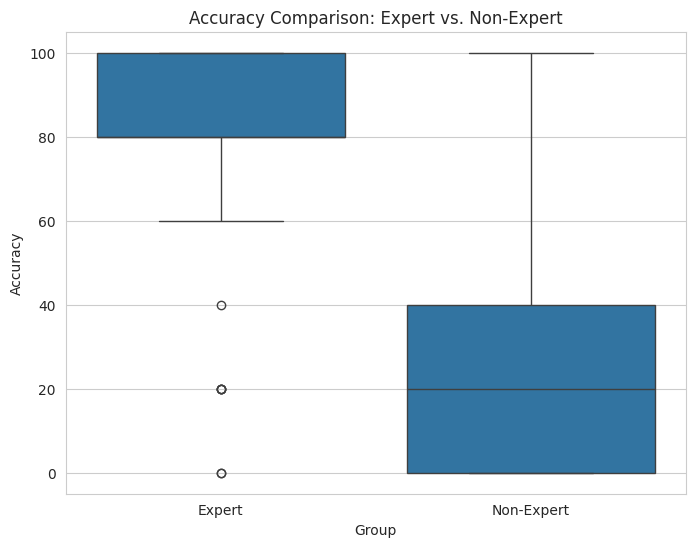

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Accuracy', data=individual_acc_df)
plt.title('Accuracy Comparison: Expert vs. Non-Expert')
plt.savefig('/content/drive/MyDrive/expert_vs_non_expert_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

Cosine Similarity Descriptive Statistics:
  SentenceType  count    mean     std
0     football      5  0.7078  0.3400
1      general      5  0.5689  0.1791

Paired t-test (General vs. Football Sentences): t=-0.71, p=0.5190


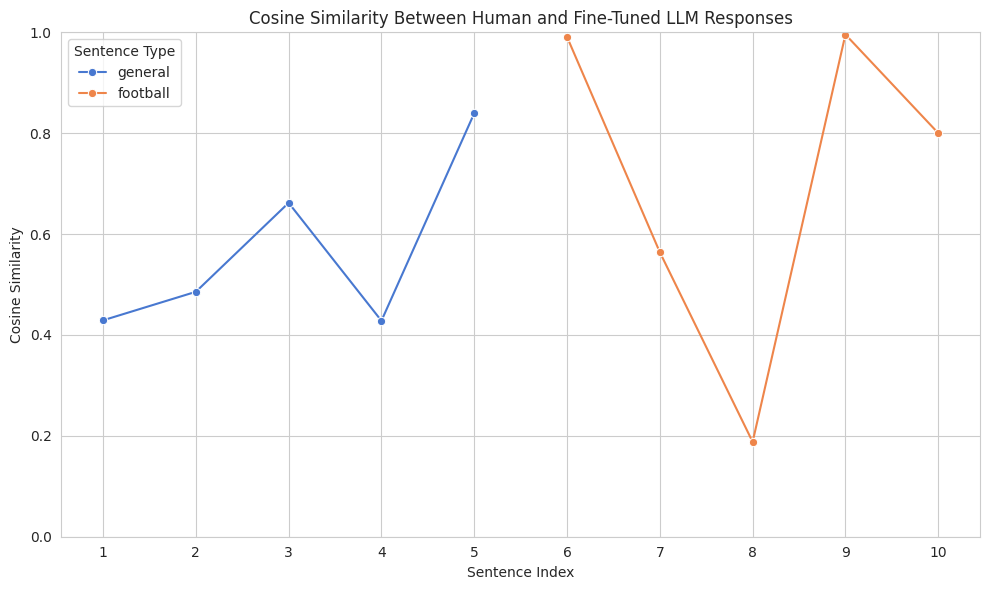

In [16]:
data = results_df

# Numerical index for x-axis
data['SentenceIndex'] = range(1, len(data) + 1)

# Descriptive statistics by SentenceType
cosine_stats = data.groupby('SentenceType')['CosineSimilarity'].agg(['count', 'mean', 'std']).reset_index()
cosine_stats['mean'] = cosine_stats['mean'].round(4)
cosine_stats['std'] = cosine_stats['std'].round(4)
print("Cosine Similarity Descriptive Statistics:")
print(cosine_stats)

# Paired t-test
general_cosine = data[data['SentenceType'] == 'general']['CosineSimilarity']
football_cosine = data[data['SentenceType'] == 'football']['CosineSimilarity']
t_stat, p_value = ttest_rel(general_cosine, football_cosine)
print(f"\nPaired t-test (General vs. Football Sentences): t={t_stat:.2f}, p={p_value:.4f}")

# Line plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='SentenceIndex', y='CosineSimilarity', hue='SentenceType', marker='o', palette='muted')
plt.title('Cosine Similarity Between Human and Fine-Tuned LLM Responses')
plt.xlabel('Sentence Index')
plt.ylabel('Cosine Similarity')
plt.ylim(0, 1)
plt.xticks(ticks=range(1, len(data) + 1), labels=range(1, len(data) + 1))
plt.legend(title='Sentence Type')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cosine_similarity.png', dpi=300)
plt.show()